<a href="https://colab.research.google.com/github/soohwahong/RL-DQN/blob/main/RL_DQN_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hyperparameter tuning**
* Stabalize training with increased batch_size and num_update_steps for q_network.
  * batch_size = 128
  * num_update_steps = 25

**Stabalizing Tricks**
*  Keep best network parameters
* Clipping gradients of error term to be -1.0 and 1.0

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00


In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+${cu121}.html

In [4]:
import gym
import collections
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import permutations
from torch_geometric.nn import GCNConv, global_add_pool, MessagePassing, MetaLayer
from torch_geometric.data import Batch, Data, DataLoader
from torch_geometric.nn.norm import LayerNorm
from torch_geometric.utils import scatter

from matplotlib import pyplot as plt

# DQN-Graph

In [5]:
# Hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000 # eps length cap is 500
batch_size = 128
num_update_steps = 25

class ReplayBuffer:
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

    def clear(self):
        self.buffer.clear()

class DQN_graph(nn.Module):
    def __init__(self, state_space=None,
                       action_space=None,
                       num_hidden_layer=2,
                       hidden_dim=None,
                       learning_rate=None):

        super(DQN_graph, self).__init__()

        # Space size check
        assert state_space is not None, "None state_space input: state_space should be assigned."
        assert action_space is not None, "None action_space input: action_space should be assigned."

        if hidden_dim is None:
            hidden_dim = state_space * 2

        self.conv1 = GCNConv(2, hidden_dim)

        # Create a list of hidden layers based on num_hidden_layer
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layer)])

        self.linear_out = nn.Linear(hidden_dim, action_space)
        self.layer_norm = LayerNorm(hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        # x = global_add_pool(self.layer_norm(x), torch.LongTensor([0 for _ in range(x.size(0))]).to(x.device))
        # pooling node features into a single fixed-size feature vector that summarizes the entire graph
        # resulting tensor has one row per graph in the batch, where each row is the sum of node features for the corresponding graph.
        x = global_add_pool(self.layer_norm(x), torch.LongTensor([0 for _ in range(x.size(0))]).to(x.device))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))

        x = self.linear_out(x) # estimated Q value
        return x

    def sample_action(self, x, edge_index, epsilon):
      '''
      sample action from q network based on epsilon-greedy policy
      '''
      out = self.forward(x, edge_index)
      coin = random.random()
      if coin < epsilon:
          return random.randint(0, 1)
      else:
          return out.argmax().item()

def create_torch_graph_data(data):
  '''
  Input
    data : list of node features [position, angle, velocity, angular velocity]
  Output
    graph : torch_geometric.data.Data with x=node_feature (2), edge_index=edge_index
  '''
  edge_index = list(permutations([i for i in range(4)], 2))
  edge_index = torch.tensor(edge_index, dtype=torch.long)
  edge_index = edge_index.t().contiguous()

  node_feature = [[data[0], data[1]], [data[2], data[3]], [data[0], data[3]], [data[1], data[2]]]
  node_feature = torch.tensor(node_feature, dtype=torch.float)

  graph_data = Data(x=node_feature, edge_index=edge_index)
  return graph_data


def create_torch_graph_data_batch(batch_data):
  '''
  Input
    batch_s : tensor where each row is a state node features [position, angle, velocity, angular velocity]
  Output
    List of data_x_list, data_edge_index_list from batch of graph Data objects
  '''
  data_x = []
  data_edge_index = []

  for data in batch_data:
      data_object = create_torch_graph_data(data)
      data_x.append(data_object.x)
      data_edge_index.append(data_object.edge_index)

  return data_x, data_edge_index


def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def train(q, q_target, memory, optimizer):
  '''
  Updates q network wrt q_target network
  '''
  for _ in range(num_update_steps):
      batch_s, batch_a, batch_r, batch_s_prime, batch_done_mask = memory.sample(batch_size) # take sample of batch_size from replay buffer

      batch_s_g_x, batch_s_g_edge_index = create_torch_graph_data_batch(batch_s)
      batch_s_prime_g_x, batch_s_prime_g_edge_index = create_torch_graph_data_batch(batch_s_prime) # List of torch_geometric.data.Data with x=node_feature, edge_index=edge_index

      # Perform forward pass for both current and next state graphs
      q_out = []
      for i in range(batch_size):
        q_out_i = q(batch_s_g_x[i].to(device), batch_s_g_edge_index[i].to(device)) # get q values for all actions
        q_out.append(q_out_i.squeeze())
      q_out = torch.stack(q_out)
      q_a = q_out.gather(1, batch_a.to(device)) # get q values for actions taken

      # get q_target values for next state (by selecting action that returns max reward)
      q_target_out = []
      for i in range(batch_size):
          q_target_out_i = q_target(batch_s_prime_g_x[i].to(device), batch_s_prime_g_edge_index[i].to(device))
          q_target_out.append(q_target_out_i.squeeze())
      q_target_out = torch.stack(q_target_out)

      max_q_prime = q_target_out.max(1)[0].unsqueeze(1)

      # Compute the target Q value using the Bellman equation
      target = batch_r.to(device) + gamma * max_q_prime * batch_done_mask.to(device)

      # Compute the loss between predicted Q values and target Q values
      loss = F.smooth_l1_loss(q_a, target) # loss between predicted q_a and target q value using Huber loss function

      # Perform backpropagation and update the network
      optimizer.zero_grad()
      loss.backward()
      # Apply gradient clipping to stabalize training
      torch.nn.utils.clip_grad_norm_(q.parameters(), 1.0)
      optimizer.step()

def save_best_model(q, best_avg_score, avg_score, save_path="best_dqn_model.pth"):
  '''
  save model if avg_score is better than best_avg_score
  updates parameters of q network if best_avg_score is updated
  '''
  if avg_score > best_avg_score:
      print(f"New best avg score: {avg_score:.2f}, saving model...")
      torch.save(q.state_dict(), save_path)
      return avg_score
  return best_avg_score

def main():
    env = gym.make('CartPole-v1')

    seed = 20
    # np.random.seed(seed)
    random.seed(seed)
    seed_torch(seed)
    env.seed(seed)
    # set parameters
    episodes = 2000
    learning_rate = 0.0005
    target_update_interval = 100 # number of episodes
    train_interval = 2000 # size of memory buffer

    q = DQN_graph(state_space=env.observation_space.shape[0],
                  action_space=env.action_space.n,
                  num_hidden_layer=1,
                  hidden_dim=128,
                  learning_rate=learning_rate).to(device)
    q_target = DQN_graph(state_space=env.observation_space.shape[0],
                         action_space=env.action_space.n,
                         num_hidden_layer=1,
                         hidden_dim=128,
                         learning_rate=learning_rate).to(device)
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    score = 0.0
    score_list = []
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    best_avg_score = float('-inf')

    for n_epi in range(episodes):
        epsilon = max(0.01, 0.08 - 0.01 * (n_epi / 200))  # Linear annealing from 8% to 1%
        # Reset the environment
        observation = env.reset()
        # print(f'observation at reset : {observation}')
        s = observation
        done = False

        while not done:
            s_g = create_torch_graph_data(s)

            a = q.sample_action(s_g.x.to(device), s_g.edge_index.to(device), epsilon)
            s_prime, r, done, truncated = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s, a, r / 100.0, s_prime, done_mask))
            s = s_prime

            score += r

            if done:
              break


        # only update target network at update intervals to prevent oscillation
        if n_epi % target_update_interval == 0 and n_epi != 0:
          avg_score = sum(score_list[-target_update_interval:])/target_update_interval
          best_avg_score = save_best_model(q, best_avg_score, avg_score) # update q network parameters if best_avg_score is updated
          print(f"episode {n_epi}, avg score : {avg_score:.2f}, eps: {epsilon * 100:.2f}%")
          q_target.load_state_dict(q.state_dict())

        # train q network wrt target network at train intervals
        if memory.size() > train_interval:
          print(f'training policy network!')
          train(q, q_target, memory, optimizer)
          memory.clear()

        # rewards +1 for every step taken, threshold is 475
        score_list.append(score)
        score = 0.0

    env.close()

    plt.plot(score_list)
    plt.title('Reward')
    plt.ylabel('reward')
    plt.xlabel('episode')
    plt.grid()
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# main()

### DQN has "catastrophic forgetting" in which performance can drop after period of learning.

- [x] Implement stale network parameters
- [x] Clipping gradients of error term to be -1.0 and 1.0

For example, in Breakout, the DQN agent may reach a point of averaging a high score over 400, and then, after another large batch of learning, it might be averaging a score of only around 200. The solution Mnih et al. [2015] propose to this problem is to simply save the network parameters that resulted in the best test performance.

One of the reasons this forgetting occurs is the inherent instability of approximating the Q-function over a large state-space using these Bellman updates. One of the main contributions of Mnih et al. [2015] was fighting this instability using experience replay and stale network parameters, as mentioned above. Additionally, Mnih et al. [2015] found that clipping the gradient of the error term to be between −1.0 and 1.0 further improved the stability of the algorithm by not allowing any single mini-batch update to change the parameters drastically.

Another reason this catastrophic forgetting occurs is that the algorithm is learning a proxy, the Q-values, for a policy instead of approximating the policy directly. A side effect of this method of policy generation is a learning update could increase the accuracy of a Q-function approximator, while decreasing the performance of the resulting policy.

Furthermore Q-values for different actions of the same state can be very similar if any of these actions does not have a significant effect on near-term reward. These small differences are the result of longer-term rewards and are therefore critical to the optimal policy. The consequence of trying to learn an approximator for this type of function is that very small errors in the Q-values can result is very different policies, making it difficult to learn long-term policies.







# EncoderDecoder graph net
Pytorch implementation of EncoderProcessDecode Block from DeepMind graph_net from Battaglia et al. (2018) Relational inductive biases, deep learning, and graph networks (https://arxiv.org/abs/1806.01261)

tensorflow implementation : https://github.com/google-deepmind/graph_nets/blob/master/graph_nets/demos/models.py

Used in Bapst et al. (2019) Structured agents for physical construction (https://arxiv.org/abs/1904.03177)

GN architecture: We use the encode-process-decode architecture described by Battaglia et al. (2018). comprised of an independent graph encoder, a recurrent graph core with separate MLPs as node, edge, and global functions followed by three GRUs, respectively, and finally as a decoder either a graph network (for the RS0 agent) or graph independent (for the DQN agent).

In symbols, given a graph observation o, we process it as e = E(o) o0 = e o′ 0=e on = G([o, on−1, o′ n−1]) o′ n = R(on−1) d = D(o′ n) (1 ≤ n ≤ nrec)

where E and D are independent graph network (see Battaglia et al. (2018)), G is a full graph network, and R is a recurrent independent graph network. We use two hidden layers of 64 units with ReLU non-linearity within all our graph networks.

For this discrete agent, the Q values are finally decoded from d as q = M ([x, dglobals]x∈dedges ), similarly to the approach of Dai et al. (2017). For the RS0 agent we find that having more than 1 recurrent steps in the recurrent graph core did not improve performance so we use a single recurrent step, and disabled the GRU (no longer needed without recurrent steps).

Recurrent Core : pytorch-geometric Tutorial 9 (https://colab.research.google.com/drive/1lhY0M2YIW5n1kTRGrarn8T61xoiSWaW6#scrollTo=KF0PSolmpDGX)


In [146]:
# https://github.com/google-deepmind/graph_nets/blob/master/graph_nets/demos/models.py code implemented for pytorch

class EncodeProcessDecode(nn.Module):
  '''
  Full encode-process-decode model.

  The model we explore includes three components:
  - An "Encoder" graph net, which independently encodes the edge, node, and
    global attributes (does not compute relations etc.).
  - A "Core" graph net, which performs N rounds of processing (message-passing)
    steps. The input to the Core is the concatenation of the Encoder's output
    and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
    the processing step).
  - A "Decoder" graph net, which independently decodes the edge, node, and
    global attributes (does not compute relations etc.), on each message-passing
    step.

                      Hidden(t)   Hidden(t+1)
                         |            ^
            *---------*  |  *------*  |  *---------*
            |         |  |  |      |  |  |         |
  Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
            |         |---->|      |     |         |
            *---------*     *------*     *---------*

  In Bapst et al. (2019) Structured agents for physical construction :

  The Encoder is an independent graph network,
    with node, edge, global network each an MLP with 2 hidden layers (64) with RELU activation
  The Core is a full graph network + individual graph recurrent network (not recurrent graph network)
    with node, edge, global network each an MLP with 2 hidden layers (64) with RELU activation
  The Decoder is an independent graph network,
    with node, edge, global network each an MLP with 2 hidden layers (64) with RELU activation

  <input output channel size>

  node_input_dim    -> [Encoder] -> node_input_dim      -> [Core] -> 64 -> [Decoder] -> node_output_size
  edge_input_dim    -> [Encoder] -> edge_input_dim      -> [Core] -> 64 -> [Decoder] -> edge_output_size
  global_input_dim  -> [Encoder] -> global_input_dim    -> [Core] -> 64 -> [Decoder] -> global_output_size

  In symbols
    Graph observation o is encoded:
      e = E(o)
    Processed through the core:
      o_0 = e, o'_0 = e
      for (1 <= n <= n_rec):
        o_n = G([o, o_n-1, o'_n-1])
        o'_n = R(o_n-1)
        where G is a full graph network, R is a recurrent independent graph network
    Decode with:
      d = D(o'_n)

  '''
  def __init__(self, node_input_dim, node_output_dim, edge_input_dim, edge_output_dim, global_input_dim, global_output_dim, hidden_dim):
      super(EncodeProcessDecode, self).__init__()
      self.encoder =  MLPGraphIndependent(node_input_size=node_input_dim,
                                         node_output_size=node_input_dim,
                                         edge_input_size=edge_input_dim,
                                         edge_output_size=edge_input_dim,
                                         global_input_size=global_input_dim,
                                         global_output_size=global_input_dim)
      self.core =     MLPGraphRecurrent(node_input_size=node_input_dim,
                                        edge_input_size=edge_input_dim,
                                        global_input_size=global_input_dim,
                                        n_rec=3)
      self.decoder =  MLPGraphIndependent(node_input_size=hidden_dim,
                                         node_output_size=node_output_dim,
                                         edge_input_size=hidden_dim,
                                         edge_output_size=edge_output_dim,
                                         global_input_size=hidden_dim,
                                         global_output_size=global_output_dim)

      # adjust output size if they don't match
      # if edge_output_size is not None:
      #     self.edge_output_transform = nn.Linear(output_dim, edge_output_size)
      # else:
      #     self.edge_output_transform = None

      # if node_output_size is not None:
      #     self.node_output_transform = nn.Linear(output_dim, node_output_size)
      # else:
      #     self.node_output_transform = None

      # if global_output_size is not None:
      #     self.global_output_transform = nn.Linear(output_dim, global_output_size)
      # else:
      #     self.global_output_transform = None

  def forward(self, data, num_processing_steps):
      x, edge_index, edge_attr, batch, global_attr = data.x, data.edge_index, data.edge_attr, data.batch, data.global_attr

      # Encode
      latent_node, latent_edge, latent_global = self.encoder(x, edge_index, edge_attr, batch, global_attr)
      latent0_node, latent0_edge, latent0_global = latent_node, latent_edge, latent_global

      output_ops = []
      for _ in range(num_processing_steps):
          # Concatenate the initial encoded state with the current state
          core_input_node = torch.cat([latent0_node, latent_node], dim=1)
          core_input_edge = torch.cat([latent0_edge, latent_edge], dim=1)
          core_input_global = torch.cat([latent0_global, latent_global], dim=1)

          # Process through the core
          latent_node, latent_edge, latent_global = self.core(core_input_node, edge_index, core_input_edge, batch, core_input_global)

          # Decode
          decoded_node, decoded_edge, decoded_global = self.decoder(latent_node, edge_index, latent_edge, batch, latent_global)

          # Apply output transformations
          if self.edge_output_transform is not None:
              decoded_edge = self.edge_output_transform(decoded_edge)
          if self.node_output_transform is not None:
              decoded_node = self.node_output_transform(decoded_node)
          if self.global_output_transform is not None:
              decoded_global = self.global_output_transform(decoded_global)

          output_ops.append((decoded_node, decoded_edge, decoded_global))

      return output_ops


# NN Modules

In [8]:
# LATENT_SIZE = 128  # Example size, adjust as needed
# NUM_LAYERS = 3  # Example number of layers, adjust as needed

class MLP(nn.Module):
  '''
  hidden dims = [LATENT_SIZE] * NUM_LAYERS
  '''
  # def __init__(self, input_dim, output_dim, hidden_dims=[LATENT_SIZE] * NUM_LAYERS):
  def __init__(self, input_dim, output_dim, hidden_dims):
      super(MLP, self).__init__()
      layers = []
      in_dim = input_dim
      for h_dim in hidden_dims:
          layers.append(nn.Linear(in_dim, h_dim))
          layers.append(nn.BatchNorm1d(h_dim))
          layers.append(nn.ReLU())
          in_dim = h_dim
      layers.append(nn.Linear(in_dim, output_dim))
      self.mlp = nn.Sequential(*layers)
      # self.layer_norm = nn.LayerNorm(output_dim)

  def forward(self, x):
      x = self.mlp(x)
      # x = self.layer_norm(x)
      return x

# MLPGraphRecurrent

In [171]:
class GRU2D(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers=3):
      super(GRU2D, self).__init__()
      self.input_dim = input_dim # 2D tuple
      self.hidden_dim = hidden_dim # 2D tuple

      # flattened size
      input_dim_flattened = self.input_dim[0] * self.input_dim[1]
      hidden_dim_flattened = self.hidden_dim[0] * self.hidden_dim[1]

      # GRU layer
      self.gru = nn.GRU(input_dim_flattened, hidden_dim_flattened, num_layers=num_layers)

  def forward(self, x, hidden):
      x_flattened = x.reshape(-1, self.input_dim[0] * self.input_dim[1])
      hidden_flattened = hidden.reshape(-1, self.hidden_dim[0] * self.hidden_dim[1])

      # print(f'--GRU2D forward pass--')
      # print(f'x_flattened : {x_flattened.shape}')
      # print(f'hidden_flattened : {hidden_flattened.shape}')
      out = self.gru(x_flattened, hidden_flattened) # output, h_n
      out = out[1].reshape(self.input_dim[0], self.input_dim[1])
      return out


In [170]:
'''

used to define recurrent core or encoder-decoder graph network
self.core = MLPGRUGraph(in_channels=output_dim, out_channels=output_dim, n_rec=3, aggr='add', bias=True)

full GN created with MetaLayer:
  https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.MetaLayer.html?highlight=metalayer
  https://jduarte.physics.ucsd.edu/capstone-particle-physics-domain/weeks/08-extending.html

'''

class MLPGraphRecurrent(nn.Module):
  '''
    Given encoded graph observation e from encoder,
    o_0 = e, o'_0 = e
    for (1 <= n <= n_rec):
      o_n = G([o, o_n-1, o'_n-1])
      o'_n = R(o_n-1)
      where G is a full graph network, R is a recurrent independent graph network

  '''
  def __init__(self,num_nodes, node_input_size, num_edges, edge_input_size, global_input_size, n_rec):
    super(MLPGraphRecurrent, self).__init__()
    self.n_rec = n_rec # number of recurrent layers
    # fully connected graph network G
    self.G = BapstFullGraphNetwork(node_input_dim=node_input_size,
                              node_output_dim=node_input_size,
                              edge_input_dim=edge_input_size,
                              edge_output_dim=edge_input_size,
                              global_input_dim=global_input_size,
                              global_output_dim=global_input_size)
    # Independent GRU networks for node, edge, global features # [TODO] : implement multiple layers?
    self.node_gru = GRU2D(input_dim=(num_nodes, node_input_size), hidden_dim=(num_nodes, node_input_size), num_layers=1)
    self.edge_gru = GRU2D(input_dim=(num_edges, edge_input_size), hidden_dim=(num_edges, edge_input_size), num_layers=1)
    self.global_gru = GRU2D(input_dim=(1, global_input_size), hidden_dim=(1, global_input_size), num_layers=1)

  def forward(self, obs, e_obs, edge_index):

    '''
    obs : current graph observation ((v,e,u) = node_input_dim, edge_input_dim, global_input_dim
    e_obs : encoded graph observation (e(v,e,u) = (64,64,64))
    Output
      o_curr_prime : node, edge, global features to be put through decoder
    '''
    o_e = e_obs # (v, e, u)
    o_e_prime = e_obs

    # updated within recurrent loop
    o_prev = o_e
    o_prev_prime = None
    o_curr_prime = o_e_prime
    concat_edge_index = torch.cat([edge_index, edge_index, edge_index], dim=1) # edge index for obs does not change

    # Recurrent processing
    for _ in range(self.n_rec):
      # print(f'-----recurrent step {_}----- ')

      if _ == 0:
        node_curr, edge_curr, global_curr = o_prev
      else:
        # Process concatenated input through G to get o_curr
        # print(f'  obs : {obs[0].shape, obs[1].shape, obs[2].shape}')
        # print(f'  o_prev : {o_prev[0].shape, o_prev[1].shape, o_prev[2].shape}')
        # print(f'  o_prev_prime : {o_prev_prime[0].shape, o_prev_prime[1].shape, o_prev_prime[2].shape}')
        input_node = torch.cat([obs[0], o_prev[0], o_prev_prime[0]], dim=0)
        input_edge = torch.cat([obs[1], o_prev[1], o_prev_prime[1]], dim=0)
        input_global = torch.cat([obs[2], o_prev[2], o_prev_prime[2]], dim=0)
        # input_batch = torch.repeat_interleave(torch.arange(3), obs[0].shape[0])# differenciate each observation by graph label for node
        num_nodes = obs[0].shape[0]
        input_batch = torch.repeat_interleave(torch.tensor([0,1,2]), num_nodes) # differenciate each observation by graph label for node
        # print(f'  input_node : {input_node.shape}')
        # print(f'  input_edge : {input_edge.shape}')
        # print(f'  input_global : {input_global.shape}')
        # print(f'  input_batch : {input_batch.shape}')

        #  o_n = G([o, o_n-1, o'_n-1])
        node_curr, edge_curr, global_curr = self.G(
                                                    x=input_node,
                                                    edge_index=concat_edge_index,
                                                    edge_attr=input_edge,
                                                    global_attr=input_global,
                                                    batch=input_batch
                                                )
        # print(f'  output from G : {node_curr.shape}, {edge_curr.shape}, {global_curr.shape}')

        o_prev = (node_curr, edge_curr, global_curr) # o_n becomes o_n-1

      # o'_n+1 = GRU(input=o_n, hidden=o'_n
      # print(f'  node_curr : {node_curr.shape}')
      # print(f'  o_curr_prime[0] : {o_curr_prime[0].shape}')
      # print(f'  edge_curr : {edge_curr.shape}')
      # print(f'  o_curr_prime[1] : {o_curr_prime[1].shape}')
      # print(f'  global_curr : {global_curr.shape}')
      # print(f'  o_curr_prime[2] : {o_curr_prime[2].shape}')
      # print(f'  o_curr : {node_curr.shape}, {edge_curr.shape}, {global_curr.shape}')
      # print(f'  o_curr_prime : {o_curr_prime[0].shape}, {o_curr_prime[1].shape}, {o_curr_prime[2].shape}')
      node_next_prime = self.node_gru(node_curr, o_curr_prime[0])
      edge_next_prime = self.edge_gru(edge_curr, o_curr_prime[1])
      global_next_prime = self.global_gru(global_curr, o_curr_prime[2])

      # update o_prev_prime to o_curr_prime and o_curr_prime to o_next_prime
      o_prev_prime = o_curr_prime #o'_n becomes o'_n-1
      o_curr_prime = (node_next_prime, edge_next_prime, global_next_prime) #o'_n+1 becomes new o'_n

    return o_curr_prime  # node_features, edge_features, global_features


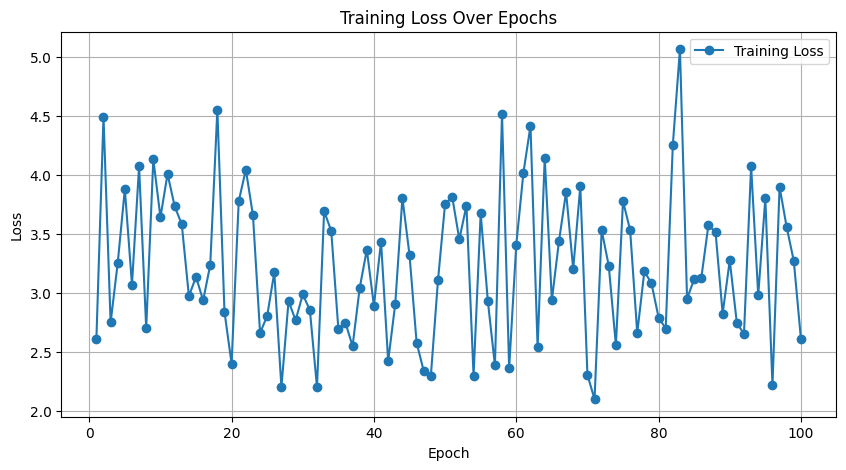

In [176]:
# Define the dimensions
num_nodes = 8
node_input_size = 10

num_edges = 12
edge_input_size = 5

# num_global is number of graphs
num_graphs = 3
global_input_size = 7

n_rec = 3


# Create an instance of the MLPGraphRecurrent class
model = MLPGraphRecurrent(num_nodes = num_nodes,
                          node_input_size=node_input_size,
                          num_edges= num_edges,
                          edge_input_size=edge_input_size,
                          global_input_size=global_input_size,
                          n_rec=n_rec)


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# List to store loss values
loss_values = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()

    # Create dummy data
    x = torch.randn(num_nodes, node_input_size)  # Node features for concatenated graphs
    edge_index = torch.randint(0, num_nodes, (2, num_edges))
    edge_attr = torch.randn(num_edges, edge_input_size)  # Edge features for concatenated graphs
    global_attr = torch.randn(1,global_input_size)

    obs = (x, edge_attr, global_attr)
    e_obs = (torch.randn((num_nodes, node_input_size)),
             torch.randn((num_edges , edge_input_size)),
             torch.randn((1,global_input_size)))

    # Run the forward pass
    output = model(obs, e_obs, edge_index)

    # Compute the target (dummy target for illustration)
    target_node_features = torch.randn_like(output[0])
    target_edge_features = torch.randn_like(output[1])
    target_global_features = torch.randn_like(output[2])

    # Compute loss
    loss_node = criterion(output[0], target_node_features)
    loss_edge = criterion(output[1], target_edge_features)
    loss_global = criterion(output[2], target_global_features)
    loss = loss_node + loss_edge + loss_global

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the loss value for plotting
    loss_values.append(loss.item())

    # Print the average loss for the epoch
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



# BapstFullGraphNetwork


In [172]:

class PrintShape(nn.Module):
  def __init__(self, name):
      super(PrintShape, self).__init__()
      self.name = name

  def forward(self, x):
      print(f"{self.name} shape:", x.shape)
      # out = super(PrintShape, self).forward(x)
      # print(f"{self.name} - Output shape:", out.shape)

      # return out
      return x


class EdgeBlock(nn.Module):
  '''
  '''
  def __init__(self, node_input_dim, edge_input_dim, edge_output_dim, global_input_dim):
      super(EdgeBlock, self).__init__()
      self.edge_mlp = nn.Sequential(
          # PrintShape("EdgeBlock-Lin Input"),
          nn.Linear(2*node_input_dim + edge_input_dim + global_input_dim, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, edge_output_dim),
          # PrintShape("EdgeBlock-Lin Output"),
      )

  def forward(self, src, dst, edge_attr, u, batch):
      # src, dst: [E, F_x], where E is the number of edges.

      # edge_attr: [E, F_e]
      # u: [B, F_u], where B is the number of graphs.
      # batch: [E] with max entry B - 1.
      # print('--EdgeModel input')
      # print(f'  src : {src.shape}')
      # print(f'  dst : {dst.shape}')
      # print(f'  edge_attr : {edge_attr.shape}')
      # print(f'  u : {u.shape}')
      # print(f'  u[batch] : {u[batch].shape}')
      out = torch.cat([src, dst, edge_attr, u[batch]], 1)
      return self.edge_mlp(out)

class NodeBlock(nn.Module):
  '''
  Input
    receives output from Edge Block
  Output
    Updated node features
  '''
  def __init__(self, node_input_dim, node_output_dim, edge_output_dim, global_input_dim):
      super(NodeBlock, self).__init__()
      self.node_mlp_1 = nn.Sequential(
          # PrintShape("NodeBlock-Lin1 Input"),
          nn.Linear(node_input_dim + edge_output_dim, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, node_input_dim), # needs to have same dim as node_input!
          # PrintShape("NodeBlock-Lin1 Output"),
      )
      self.node_mlp_2 = nn.Sequential(
          # PrintShape("NodeBlock-Lin2 Input"),
          nn.Linear(node_input_dim*2 + global_input_dim, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, node_output_dim),
          # PrintShape("NodeBlock-Lin2 Output"),
      )


  def forward(self, x, edge_index, edge_attr, u, batch):
    # x: [N, F_x], where N is the number of nodes.
    # edge_index: [2, E] with max entry N - 1.
    # edge_attr: [E, F_e]
    # u: [B, F_u], where B is the number of graphs.
    # batch: [N] with max entry B - 1.
    # print('--NodeModel')
    row, col = edge_index
    # print(f'  row : {row.shape}')
    # print(f'  col : {col.shape}')
    # print(f'  edge_attr : {edge_attr.shape}')
    # print(f'  x[row] : {x[row].shape}')
    # print(f'  u : {u.shape}')
    out = torch.cat([x[row], edge_attr], dim=1)
    out = self.node_mlp_1(out) # needs to have same dim as node_input
    out = scatter(out, col, dim=0, dim_size=x.size(0), reduce='mean')
    # print(f'  mlp_1 out scatter : {out.shape}')
    # print(f'  x : {x.shape}')
    # print(f'  u[batch] : {u[batch].shape}')
    out = torch.cat([x, out, u[batch]], dim=1)
    res = self.node_mlp_2(out)
    # print(f'  mlp_2 res : {res.shape}')
    return res

class GlobalBlock(nn.Module):
    '''
  Input
    receives output from Node Block
  Output
    Updated global features
  '''
    def __init__(self, global_input_dim, global_output_dim, node_output_dim):
      super(GlobalBlock, self).__init__()
      self.global_mlp = nn.Sequential(
          # PrintShape("GlobalBlock-Lin Input"),
          nn.Linear(node_output_dim + global_input_dim, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, global_output_dim),
          # PrintShape("GlobalBlock-Lin Output"),
      )

    def forward(self, x, edge_index, edge_attr, u, batch):
      # x: [N, F_x], where N is the number of nodes.
      # edge_index: [2, E] with max entry N - 1.
      # edge_attr: [E, F_e]
      # u: [B, F_u]
      # batch: [N] with max entry B - 1.

      # print(f'--GlobalModel')
      # print(f'  u : {u.shape}')
      scattered_x = scatter(x, batch, dim=0, reduce='mean')
      # print(f'  x : {x.shape}')
      # print(f'  scattered x : {scattered_x.shape}')
      out = torch.cat([
          u,
          scatter(x, batch, dim=0, reduce='mean'), # message passing across nodes within each batch (take aggregate of nodes within same batch)
      ], dim=1)
      return self.global_mlp(out)
class FullGraphNetwork(nn.Module):
  '''
  Full graph network + linear layer to reduce dimension
  input of the FullGraphNetwork is 3 graphs concatenated,
  with linear layers for node, edge and graph
  output is reduced to 1 graph
  '''
  def __init__(self, node_input_dim, node_output_dim, edge_input_dim, edge_output_dim, global_input_dim, global_output_dim):
      super(FullGraphNetwork, self).__init__()
      self.meta = MetaLayer(EdgeBlock(node_input_dim, edge_input_dim, edge_output_dim, global_input_dim),
                            NodeBlock(node_input_dim, node_output_dim, edge_output_dim, global_input_dim),
                            GlobalBlock(global_input_dim, global_output_dim, node_output_dim))
      # self.bn = nn.BatchNorm1d(node_input_dim)

  def forward(self, x, edge_index, edge_attr, global_attr, batch):
    # x: [N, F_x], where N is the number of nodes.
    # edge_index: [2, E] with max entry N - 1.
    # edge_attr: [E, F_e]
    # u: [B, F_u], where B is the number of graphs.
    # batch: [N] with max entry B - 1.
    # x = self.bn(x) # node attributes
    node_features, edge_features, global_features = self.meta(x=x, edge_index=edge_index, edge_attr=edge_attr, u=global_attr, batch=batch)

    return node_features, edge_features, global_features

class BapstFullGraphNetwork(nn.Module):
  '''
  Full graph network + linear layer to reduce dimension
  input of the FullGraphNetwork is 3 graphs concatenated,
  with linear layers for node, edge and graph
  output is reduced to 1 graph
  '''
  def __init__(self, node_input_dim, node_output_dim, edge_input_dim, edge_output_dim, global_input_dim, global_output_dim):
      super(BapstFullGraphNetwork, self).__init__()
      self.meta = MetaLayer(EdgeBlock(node_input_dim, edge_input_dim, edge_output_dim, global_input_dim),
                            NodeBlock(node_input_dim, node_output_dim, edge_output_dim, global_input_dim),
                            GlobalBlock(global_input_dim, global_output_dim, node_output_dim))
      # self.bn = nn.BatchNorm1d(node_input_dim)
      # Linear layers for dimensionality reduction
      self.node_reduce = nn.Linear(node_output_dim * 3, node_output_dim)
      self.edge_reduce = nn.Linear(edge_output_dim * 3, edge_output_dim)
      self.global_reduce = nn.Linear(global_output_dim * 3, global_output_dim)

  def forward(self, x, edge_index, edge_attr, global_attr, batch):
    # x: [N, F_x], where N is the number of nodes.
    # edge_index: [2, E] with max entry N - 1.
    # edge_attr: [E, F_e]
    # u: [B, F_u], where B is the number of graphs.
    # batch: [N] with max entry B - 1.
    # x = self.bn(x) # node attributes
    node_features, edge_features, global_features = self.meta(x=x, edge_index=edge_index, edge_attr=edge_attr, u=global_attr, batch=batch)

    # Concatenate the features along the last dimension
    node_features = node_features.view(-1, node_features.size(-1) * 3)
    edge_features = edge_features.view(-1, edge_features.size(-1) * 3)
    global_features = global_features.view(-1, global_features.size(-1) * 3)

    # Apply linear layers to reduce dimensions
    node_features = self.node_reduce(node_features)
    edge_features = self.edge_reduce(edge_features)
    global_features = self.global_reduce(global_features)

    return node_features, edge_features, global_features


## Test FullGraphNetwork

In [95]:
# Create a sample graph data and target attributes
node_input_dim, node_output_dim = 12, 10
edge_input_dim, edge_output_dim = 12, 15
global_input_dim, global_output_dim = 12, 6
num_nodes = 6
num_graphs = 2

x = torch.randn(num_nodes, node_input_dim)  # Node features for 5 nodes
edge_index = torch.tensor([[0, 1, 1, 2, 3], [1, 0, 2, 1, 4]])  # Example edge indices
edge_attr = torch.randn(edge_index.size(1), edge_input_dim)  # Edge features for 5 edges
global_attr = torch.randn(num_graphs, global_input_dim)
batch = torch.tensor([0, 0, 0, 1, 1, 1])  # Batch information for each node

# Create a target tensor for node, edge, and global attributes
target_node = torch.randn(num_nodes, node_output_dim)  # Target node features for 5 nodes
target_edge = torch.randn(len(edge_index[0]), edge_output_dim)  # Target edge features for 5 edges
target_global = torch.randn(num_graphs, global_output_dim)  # Target global features for 2 batches
target_data = (target_node, target_edge, target_global)

# Create a DataLoader with the sample graph and target data
dataset = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, global_attr=global_attr, batch=batch) # batch argument doesn't register as batch
data_loader = DataLoader([(dataset, target_data)])


print(len(data_loader))

1


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [96]:
# Initialize the FullGraphNetwork model and optimizer
model = FullGraphNetwork(node_input_dim, node_output_dim, edge_input_dim, edge_output_dim, global_input_dim, global_output_dim)
# for name, param in model.named_parameters():
#   print(f'{name}')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

--EdgeModel input
  src : torch.Size([5, 12])
  dst : torch.Size([5, 12])
  edge_attr : torch.Size([5, 12])
  u[batch] : torch.Size([5, 12])
EdgeBlock-Lin Input shape: torch.Size([5, 48])
EdgeBlock-Lin Output shape: torch.Size([5, 15])
--NodeModel
  row : torch.Size([5])
  col : torch.Size([5])
  edge_attr : torch.Size([5, 15])
  x[row] : torch.Size([5, 12])
NodeBlock-Lin1 Input shape: torch.Size([5, 27])
NodeBlock-Lin1 Output shape: torch.Size([5, 12])
  mlp_1 out scatter : torch.Size([6, 12])
  x : torch.Size([6, 12])
  u[batch] : torch.Size([6, 12])
NodeBlock-Lin2 Input shape: torch.Size([6, 36])
NodeBlock-Lin2 Output shape: torch.Size([6, 10])
  mlp_2 res : torch.Size([6, 10])
--GlobalModel
  u : torch.Size([2, 12])
  x : torch.Size([6, 10])
  scattered x : torch.Size([2, 10])
GlobalBlock-Lin Input shape: torch.Size([2, 22])
GlobalBlock-Lin Output shape: torch.Size([2, 6])
--EdgeModel input
  src : torch.Size([5, 12])
  dst : torch.Size([5, 12])
  edge_attr : torch.Size([5, 12])
  

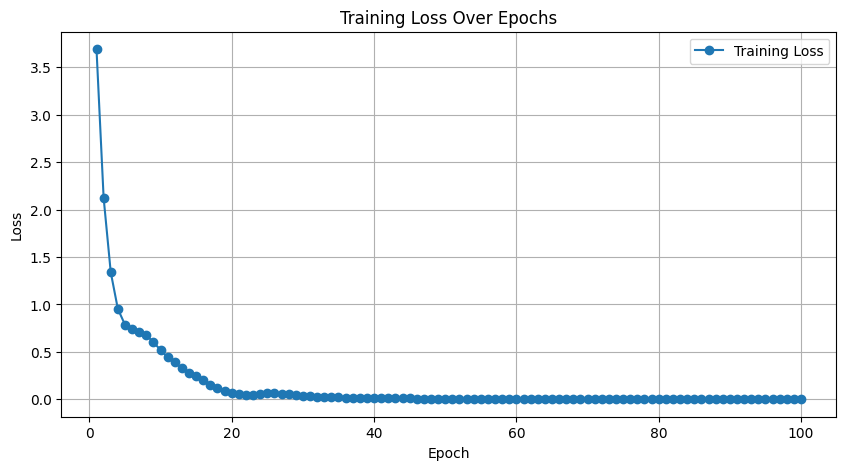

In [97]:
# Train the model
num_epochs = 100  # Define the number of epochs
avg_losses = []  # List to store average losses for each epoch

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0  # Initialize total loss for the epoch

    for data, target in data_loader:
      optimizer.zero_grad()
      node_features, edge_features, global_features = model(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, global_attr=data.global_attr, batch=batch)

      # Compute loss using target attributes
      loss_node = torch.nn.functional.mse_loss(node_features.unsqueeze(0), target[0])
      loss_edge = torch.nn.functional.mse_loss(edge_features.unsqueeze(0), target[1])
      loss_global = torch.nn.functional.mse_loss(global_features.unsqueeze(0), target[2])
      loss = loss_node + loss_edge + loss_global

      # Perform backpropagation and update the network
      loss.backward()

      # Print gradient norms
      # for name, param in model.named_parameters():
      #     if param.grad is not None:
      #         print(f"{name}: {param.grad.norm().item()}")

      total_loss += loss.item()
      optimizer.step()


    # Compute and print average loss for the epoch
    avg_loss = total_loss / len(data_loader)
    avg_losses.append(avg_loss)
    # print(f'Epoch {epoch + 1}, Avg Loss: {avg_loss:.4f}')

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), avg_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('withbatchnormatend')
plt.show()


# Recurrent GN Block (obsolete)

In [ ]:
class MLP_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(MLP_GRU, self).__init__()
        layers = []
        in_dim = input_dim
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))

        self.mlp = nn.Sequential(*layers)
        print(f'mlp of mlp_gru : {self.mlp}')
        self.gru = nn.GRUCell(output_dim, output_dim) # input size, hidden size 3,3

    def forward(self, x, hx):
        x = self.mlp(x) # 3
        hx = self.gru(x, hx) # outputs next hidden state
        print(f'forward pass of MLP GRU returns x : {hx.shape}')

        return hx

In [ ]:
class MLPGatedGraphConv(MessagePassing):
    def __init__(self, in_channels, out_channels, num_layers, aggr='add', bias=True, **kwargs):
        super(MLPGatedGraphConv, self).__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels

        self.node_gru = MLP_GRU(in_channels, out_channels, out_channels, num_layers)
        self.edge_gru = MLP_GRU(in_channels, out_channels, out_channels, num_layers)
        self.global_gru = MLP_GRU(in_channels, out_channels, out_channels, num_layers)

        self.reset_parameters()

    def reset_parameters(self):
      for l_n in self.node_gru.mlp.children():
          if isinstance(l_n, nn.Linear):
              nn.init.xavier_uniform_(l_n.weight)
              if l_n.bias is not None:
                  nn.init.zeros_(l_n.bias)

      for l_e in self.edge_gru.mlp.children():
          if isinstance(l_e, nn.Linear):
              nn.init.xavier_uniform_(l_e.weight)
              if l_e.bias is not None:
                  nn.init.zeros_(l_e.bias)

      for l_g in self.global_gru.mlp.children():
          if isinstance(l_g, nn.Linear):
              nn.init.xavier_uniform_(l_g.weight)
              if l_g.bias is not None:
                  nn.init.zeros_(l_g.bias)



    def forward(self, x, edge_index, edge_attr=None, batch=None, global_attr=None):
        # Pad 0s if size mismatch
        # Node features
        if x.size(-1) < self.out_channels:
            zero = x.new_zeros(x.size(0), self.out_channels - x.size(-1))
            x = torch.cat([x, zero], dim=1)

        # Edge features
        if edge_attr is not None and edge_attr.size(-1) < self.out_channels:
            zero = edge_attr.new_zeros(edge_attr.size(0), self.out_channels - edge_attr.size(-1))
            edge_attr = torch.cat([edge_attr, zero], dim=1)

        # Global features
        if global_attr is not None and global_attr.size(-1) < self.out_channels:
            zero = global_attr.new_zeros(global_attr.size(0), self.out_channels - global_attr.size(-1))
            global_attr = torch.cat([global_attr, zero], dim=1)

        # Initialize hidden states
        hx_node = torch.zeros((x.shape[0], self.out_channels)) # needs to be 3 instead of 5
        hx_edge = torch.zeros((edge_attr.shape[0], self.out_channels )) if edge_attr is not None else None
        hx_global = torch.zeros((global_attr.shape[0], self.out_channels)) if global_attr is not None else None

        print(f'forwarding  MLPGatedGraphConv... x shape : {x.shape}, hx shape : {hx_node.shape}')
        x = self.node_gru(x, hx_node)
        # hx_node = x
        if edge_attr is not None:
            edge_attr = self.edge_gru(edge_attr, hx_edge)
            # hx_edge = edge_attr
        if global_attr is not None:
            global_attr = self.global_gru(global_attr, hx_global)
            # hx_global = global_attr

        node_feature = self.propagate(edge_index, x=x, edge_attr=edge_attr, global_attr=global_attr, size=None)

        return node_feature, edge_attr

    # def message(self, x_j, edge_attr):
    #   '''Constructs messages from node :math:`j` to node :math:`i`
    #     in analogy to :math:`\phi_{\mathbf{\Theta}}` for each edge in
    #     :obj:`edge_index`.
    #     This function can take any argument as input which was initially
    #     passed to :meth:`propagate`.
    #     Furthermore, tensors passed to :meth:`propagate` can be mapped to the
    #     respective nodes :math:`i` and :math:`j` by appending :obj:`_i` or
    #     :obj:`_j` to the variable name, *.e.g.* :obj:`x_i` and :obj:`x_j`.
    #   x_j receives messages from neighbor nodes that are weighted by edge features
    #   x_j : node that is aggregating info
    #   edge_attr : edge feature
    #   '''
    #     return x_j if edge_attr is None else edge_attr.view(-1, 1) * x_j

    # def message_and_aggregate(self, adj_t, x):
    #     return torch.matmul(adj_t, x, reduce=self.aggr)

    # def aggregate(self,
    #               inputs: Tensor,
    #               index: Tensor,
    #               ptr: Optional[Tensor] = None,
    #               dim_size: Optional[int] = None,
    #               ) -> Tensor:
    #   '''
    #   Aggregates messages from neighbors as
    #     :math:`\bigoplus_{j \in \mathcal{N}(i)}`.

    #     Takes in the output of message computation as first argument and any
    #     argument which was initially passed to :meth:`propagate`.

    #     By default, this function will delegate its call to the underlying
    #     :class:`~torch_geometric.nn.aggr.Aggregation` module to reduce messages
    #     as specified in :meth:`__init__` by the :obj:`aggr` argument.
    #   '''
    #   return scatter(inputs, index, dim=0, reduce=self.aggr)

    # def update(self, aggr_out):
    #   '''
    #   Updates node embeddings in analogy to
    #     :math:`\gamma_{\mathbf{\Theta}}` for each node
    #     :math:`i \in \mathcal{V}`.
    #     Takes in the output of aggregation as first argument and any argument
    #     which was initially passed to :meth:`propagate`.
    #   '''
    #   return aggr_out

    # TODO : does this work properly?
    # def propagate(
    #               self,
    #               edge_index: Adj,
    #               size: Size = None,
    #               **kwargs: Any,
    #           ) -> Tensor:
        r"""The initial call to start propagating messages.

        Args:
            edge_index (torch.Tensor or SparseTensor): A :class:`torch.Tensor`,
                a :class:`torch_sparse.SparseTensor` or a
                :class:`torch.sparse.Tensor` that defines the underlying
                graph connectivity/message passing flow.
            size ((int, int), optional): The size :obj:`(N, M)` of the
                assignment matrix in case :obj:`edge_index` is a
                :class:`torch.Tensor`.
                If set to :obj:`None`, the size will be automatically inferred
                and assumed to be quadratic.
            **kwargs: Any additional data which is needed to construct and
                aggregate messages, and to update node embeddings.
        """

        # coll_dict = self.__collect__(self.__user_args__, edge_index, size, kwargs)
        # msg_kwargs = self.inspector.distribute('message', coll_dict)
        # out = self.message(**msg_kwargs)
        # aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
        # out = self.aggregate(out, **aggr_kwargs)
        # update_kwargs = self.inspector.distribute('update', coll_dict)
        # out = self.update(out, **update_kwargs)
        # return out, kwargs.get('edge_attr'), kwargs.get('global_attr')

    def __repr__(self):
        return '{}({}, num_layers={})'.format(self.__class__.__name__, self.out_channels, self.num_layers)

In [ ]:
# Create a small synthetic graph
num_nodes = 10
num_edges = 20
in_channels = 5
out_channels = 3
num_layers = 3

x = torch.rand((num_nodes, in_channels))  # Node features
edge_index = torch.randint(0, num_nodes, (2, num_edges))  # Edge indices
edge_attr = torch.rand((num_edges, in_channels))  # Edge features
global_attr = torch.rand((1, in_channels))  # Global feature

# Create a Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, global_attr=global_attr)

# Initialize the model, loss function, and optimizer
model = MLPGatedGraphConv(in_channels, out_channels, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Target tensor (for simplicity, let's use random targets)
target = torch.ones((num_nodes, out_channels))

# Training loop
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    node_features, edge_features = model(data.x, data.edge_index, data.edge_attr, data.batch, data.global_attr)
    print(out)
    loss = criterion(out, target)
    print(f'out : {out}')
    print(f'target : {target}')
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training finished!")

In [ ]:
# # from pytorch-geometric tutorial
# from torch_geometric.nn.conv import MessagePassing
# class GatedGraphConv(MessagePassing):

#     def __init__(self, out_channels, num_layers, aggr = 'add',
#                  bias = True, **kwargs):
#         super(GatedGraphConv, self).__init__(aggr=aggr, **kwargs)

#         self.out_channels = out_channels
#         self.num_layers = num_layers

#         self.weight = Param(Tensor(num_layers, out_channels, out_channels))
#         self.rnn = torch.nn.GRUCell(out_channels, out_channels, bias=bias)

#         self.reset_parameters()

#     def reset_parameters(self):
#         uniform(self.out_channels, self.weight)
#         self.rnn.reset_parameters()

#     def forward(self, data):
#         """"""
#         x = data.x
#         edge_index = data.edge_index
#         edge_weight = data.edge_attr
#         if x.size(-1) > self.out_channels:
#             raise ValueError('The number of input channels is not allowed to '
#                              'be larger than the number of output channels')

#         if x.size(-1) < self.out_channels:
#             zero = x.new_zeros(x.size(0), self.out_channels - x.size(-1))
#             x = torch.cat([x, zero], dim=1)

#         for i in range(self.num_layers):
#             m = torch.matmul(x, self.weight[i])
#             m = self.propagate(edge_index, x=m, edge_weight=edge_weight,
#                                size=None)
#             x = self.rnn(m, x) # Update node features using the GRU cell with the propagated messages and previous node features.

#         return x

#     def message(self, x_j, edge_weight):
#         return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

#     def message_and_aggregate(self, adj_t, x):
#         return matmul(adj_t, x, reduce=self.aggr)

#     def __repr__(self):
#         return '{}({}, num_layers={})'.format(self.__class__.__name__,
#                                               self.out_channels,
#                                               self.num_layers)

# Independent Graph Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, Batch
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp



class MLPGraphIndependent(nn.Module):
    def __init__(self, node_input_size, node_output_size, edge_input_size, edge_output_size, global_input_size, global_output_size):
        super(MLPGraphIndependent, self).__init__()
        self.node_model = MLP(node_input_size, node_output_size)
        self.edge_model = MLP(edge_input_size, edge_output_size)
        self.global_model = MLP(global_input_size, global_output_size)

    def forward(self, x, edge_index, edge_attr, batch, global_attr):
        if edge_attr is not None:
            edge_features = self.edge_model(edge_attr)
        if x is not None:
            x = self.node_model(x)
        if global_attr is not None:
            global_features = self.global_model(global_attr)
        return x, edge_features, global_features



In [ ]:

# Example usage
node_input_dim = 10
edge_input_dim = 5
global_input_dim = 3
node_output_dim = 20
edge_output_dim = 10
global_output_dim = 5

# Create the MLPGraphIndependent model
model = MLPGraphIndependent(node_input_dim, node_output_dim, edge_input_dim, edge_output_dim, global_input_dim, global_output_dim)

# Example input data
num_nodes = 10
num_edges = 20
node_features = torch.randn(num_nodes, node_input_dim)
edge_index = torch.randint(0, num_nodes, (2, num_edges))
edge_attr = torch.randn(num_edges, edge_input_dim)
batch = torch.zeros(num_nodes, dtype=torch.long)  # Assuming all nodes belong to the same graph
global_attr = torch.randn(1, global_input_dim)

print(f'''original edge_index : {edge_index},
          edge_attr : {edge_attr},
          node_features : {node_features},
          global_attr : {global_attr}''')



# Forward pass through the model
node_output, edge_output, global_output = model(node_features, edge_index, edge_attr, batch, global_attr)
# Print model weights
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name} - Weights: {param.data}')
        print(f'{name} - Gradients: {param.grad}')

print(f'''node output : {node_output},
          edge output : {edge_output},
          global output : {global_output}
          ''')

In [ ]:
rnn = nn.GRUCell(10, 20) # input size, hidden size

input = torch.randn(6, 3, 10)
hx = torch.randn(3, 20)
output = []

# print(f'input : {input}')
# print(f'hidden layer : {hx}')
for i in range(6):
    hx = rnn(input[i], hx)
    output.append(hx)
print(f'output : {output[0].size()}') # list of 6 [3,20]